In [71]:
!pip install catboost

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.metrics import recall_score,fbeta_score, make_scorer, confusion_matrix,accuracy_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgbm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Importing DataFrame

In [ ]:
df = pd.read_csv('train_dataset_final1.csv')
df2 = pd.read_csv('validate_dataset_final.csv')
df.head()
df.isnull().sum()
df2.isnull().sum()

,0
Customer_ID,0
marriage,0
sex,0
education,0
LIMIT_BAL,0
age,0
pay_0,0
pay_2,0
pay_3,0
pay_4,0


### Removing Null value

In [ ]:
### Dropping age with null values as they are only 126 and dropping them will not effect data
df.dropna(subset=['age'],inplace=True)


# Feature Engineering

## Imbalance Handling Using SMOTE

In [ ]:
smote = SMOTE()

In [ ]:
X = df.iloc[:,:-1]
y = df['next_month_default']

In [ ]:
x_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
df_final = pd.DataFrame(x_smote, columns=df.columns[:-1])
df_final['next_month_default'] = y_smote

df_final.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


## Checking Data balance

<Axes: xlabel='next_month_default', ylabel='count'>

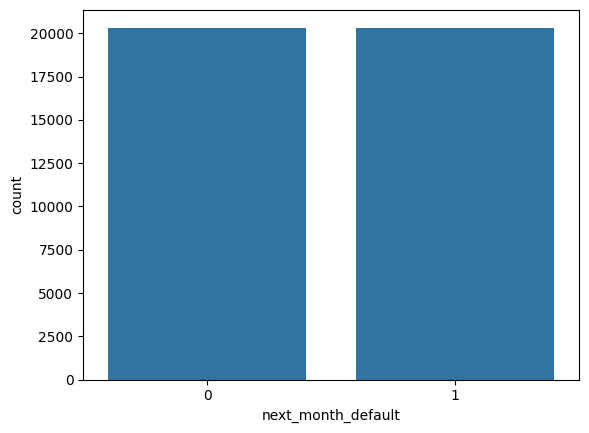

In [ ]:
sns.countplot(x='next_month_default', data=df_final)

In [ ]:
df_final.next_month_default.value_counts()

,count
next_month_default,
0,20337
1,20337


In [ ]:
df.marriage.value_counts()

,count
marriage,
2,13374
1,11424
3,270
0,53


## Replacing Categorical Columns with Original Values

In [ ]:
df_final['sex'] = df_final['sex'].replace({1:'Male',0:'Female'})
df_final['education']= df_final['education'].replace({1:'Graduate School', 2:'University', 3:'High School',0:'Others',4:'Others',5:'Others',6:'Others' })
df_final['marriage'] = df_final['marriage'].replace({1:'Married',2:'No',3:'Others',0:'Others'})

df2['sex'] = df2['sex'].replace({1:'Male',0:'Female'})
df2['education']= df2['education'].replace({1:'Graduate School', 2:'University', 3:'High School',0:'Others',4:'Others',5:'Others',6:'Others' })
df2['marriage'] = df2['marriage'].replace({1:'Married',2:'No',3:'Others',0:'Others'})


In [ ]:
df_final.head()
df2.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,Married,Male,University,220000,32,0,0,0,0,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,No,Female,Graduate School,350000,35,-1,-1,-1,0,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,No,Male,Graduate School,310000,39,0,0,0,0,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,Married,Female,University,20000,47,0,0,0,2,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,No,Male,University,500000,30,0,0,0,0,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


## Replacing Months with original name

In [ ]:
df_final.rename(columns= {'pay_6':'Pay_January','pay_5':'Pay_February','pay_4':'Pay_March','pay_3':'Pay_April','pay_2':'Pay_May','pay_0':'Pay_June'},inplace=True)
df_final.rename(columns= {'pay_amt6':'Pay_amt_January','pay_amt5':'Pay_amt_February','pay_amt4':'Pay_amt_March','pay_amt3':'Pay_amt_April','pay_amt2':'Pay_amt_May','pay_amt1':'Pay_amt_June'},inplace=True)
df_final.rename(columns= {'Bill_amt6':'Bill_amt_January','Bill_amt5':'Bill_amt_February','Bill_amt4':'Bill_amt_March','Bill_amt3':'Bill_amt_April','Bill_amt2':'Bill_amt_May','Bill_amt1':'Bill_amt_June'},inplace=True)

df2.rename(columns= {'pay_6':'Pay_January','pay_5':'Pay_February','pay_4':'Pay_March','pay_3':'Pay_April','pay_2':'Pay_May','pay_0':'Pay_June'},inplace=True)
df2.rename(columns= {'pay_amt6':'Pay_amt_January','pay_amt5':'Pay_amt_February','pay_amt4':'Pay_amt_March','pay_amt3':'Pay_amt_April','pay_amt2':'Pay_amt_May','pay_amt1':'Pay_amt_June'},inplace=True)
df2.rename(columns= {'Bill_amt6':'Bill_amt_January','Bill_amt5':'Bill_amt_February','Bill_amt4':'Bill_amt_March','Bill_amt3':'Bill_amt_April','Bill_amt2':'Bill_amt_May','Bill_amt1':'Bill_amt_June'},inplace=True)

In [ ]:
df_final.head()
df2.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,Pay_June,Pay_May,Pay_April,Pay_March,...,Bill_amt_February,Bill_amt_January,Pay_amt_June,Pay_amt_May,Pay_amt_April,Pay_amt_March,Pay_amt_February,Pay_amt_January,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,Married,Male,University,220000,32,0,0,0,0,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,No,Female,Graduate School,350000,35,-1,-1,-1,0,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,No,Male,Graduate School,310000,39,0,0,0,0,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,Married,Female,University,20000,47,0,0,0,2,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,No,Male,University,500000,30,0,0,0,0,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


In [ ]:
df_final.shape

(40674, 27)

## Encoding Categorical variables

In [ ]:
df_final = pd.get_dummies(df_final, columns=['marriage','education','sex'])
df2 = pd.get_dummies(df2, columns=['marriage','education','sex'])

In [ ]:
df_final.head()

,Customer_ID,LIMIT_BAL,age,Pay_June,Pay_May,Pay_April,Pay_March,Pay_February,Pay_January,Bill_amt_June,...,next_month_default,marriage_Married,marriage_No,marriage_Others,education_Graduate School,education_High School,education_Others,education_University,sex_Female,sex_Male
0,5017,60000,25.0,2,2,2,0,0,0,60323.86,...,0,False,True,False,False,False,False,True,True,False
1,5018,290000,24.0,0,0,-2,-2,-1,0,11157.67,...,0,False,True,False,True,False,False,False,False,True
2,5019,180000,63.0,0,0,0,0,0,0,47930.96,...,0,True,False,False,False,False,False,True,True,False
3,5020,210000,43.0,0,0,0,0,0,0,91152.44,...,0,True,False,False,False,False,False,True,False,True
4,5021,280000,32.0,-2,-2,-2,-2,-2,-2,19666.40,...,0,False,True,False,True,False,False,False,True,False


## Train Test Split

In [ ]:
X= df_final.drop(columns='next_month_default',axis=1)
y= df_final['next_month_default']


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Applying RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=6)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=6)

In [ ]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)
val_pred = rf.predict(df2)
np.count_nonzero(val_pred == 1)

115

In [ ]:
train_recall_score = recall_score(y_train,train_pred)
test_recall_score = recall_score(y_test,test_pred)

In [ ]:
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)

print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)

Accuracy:  0.870559311616472
Precision:  0.8865979381443299
Recall:  0.8541666666666666
F1 Score:  0.8700801974090068


## Feature Selection

In [ ]:
rf.feature_importances_

array([0.03802725, 0.03970937, 0.04080501, 0.08380526, 0.04392825,
       0.03108776, 0.02761696, 0.02070037, 0.01438413, 0.0429283 ,
       0.03802151, 0.03669816, 0.03453269, 0.03472122, 0.03393914,
       0.05263884, 0.04680739, 0.04211794, 0.03917968, 0.03781812,
       0.03987382, 0.04148108, 0.04075222, 0.01979629, 0.01813707,
       0.00076325, 0.00751371, 0.01203398, 0.0011519 , 0.00558201,
       0.01440479, 0.01904252])

In [ ]:
feature_scores = pd.Series(rf.feature_importances_, index=df_final.drop(columns='next_month_default',axis=1).columns).sort_values(ascending=False)
feature_scores

,0
Pay_June,0.083805
Pay_amt_June,0.052639
Pay_amt_May,0.046807
Pay_May,0.043928
Bill_amt_June,0.042928
Pay_amt_April,0.042118
AVG_Bill_amt,0.041481
age,0.040805
PAY_TO_BILL_ratio,0.040752
Pay_amt_January,0.039874


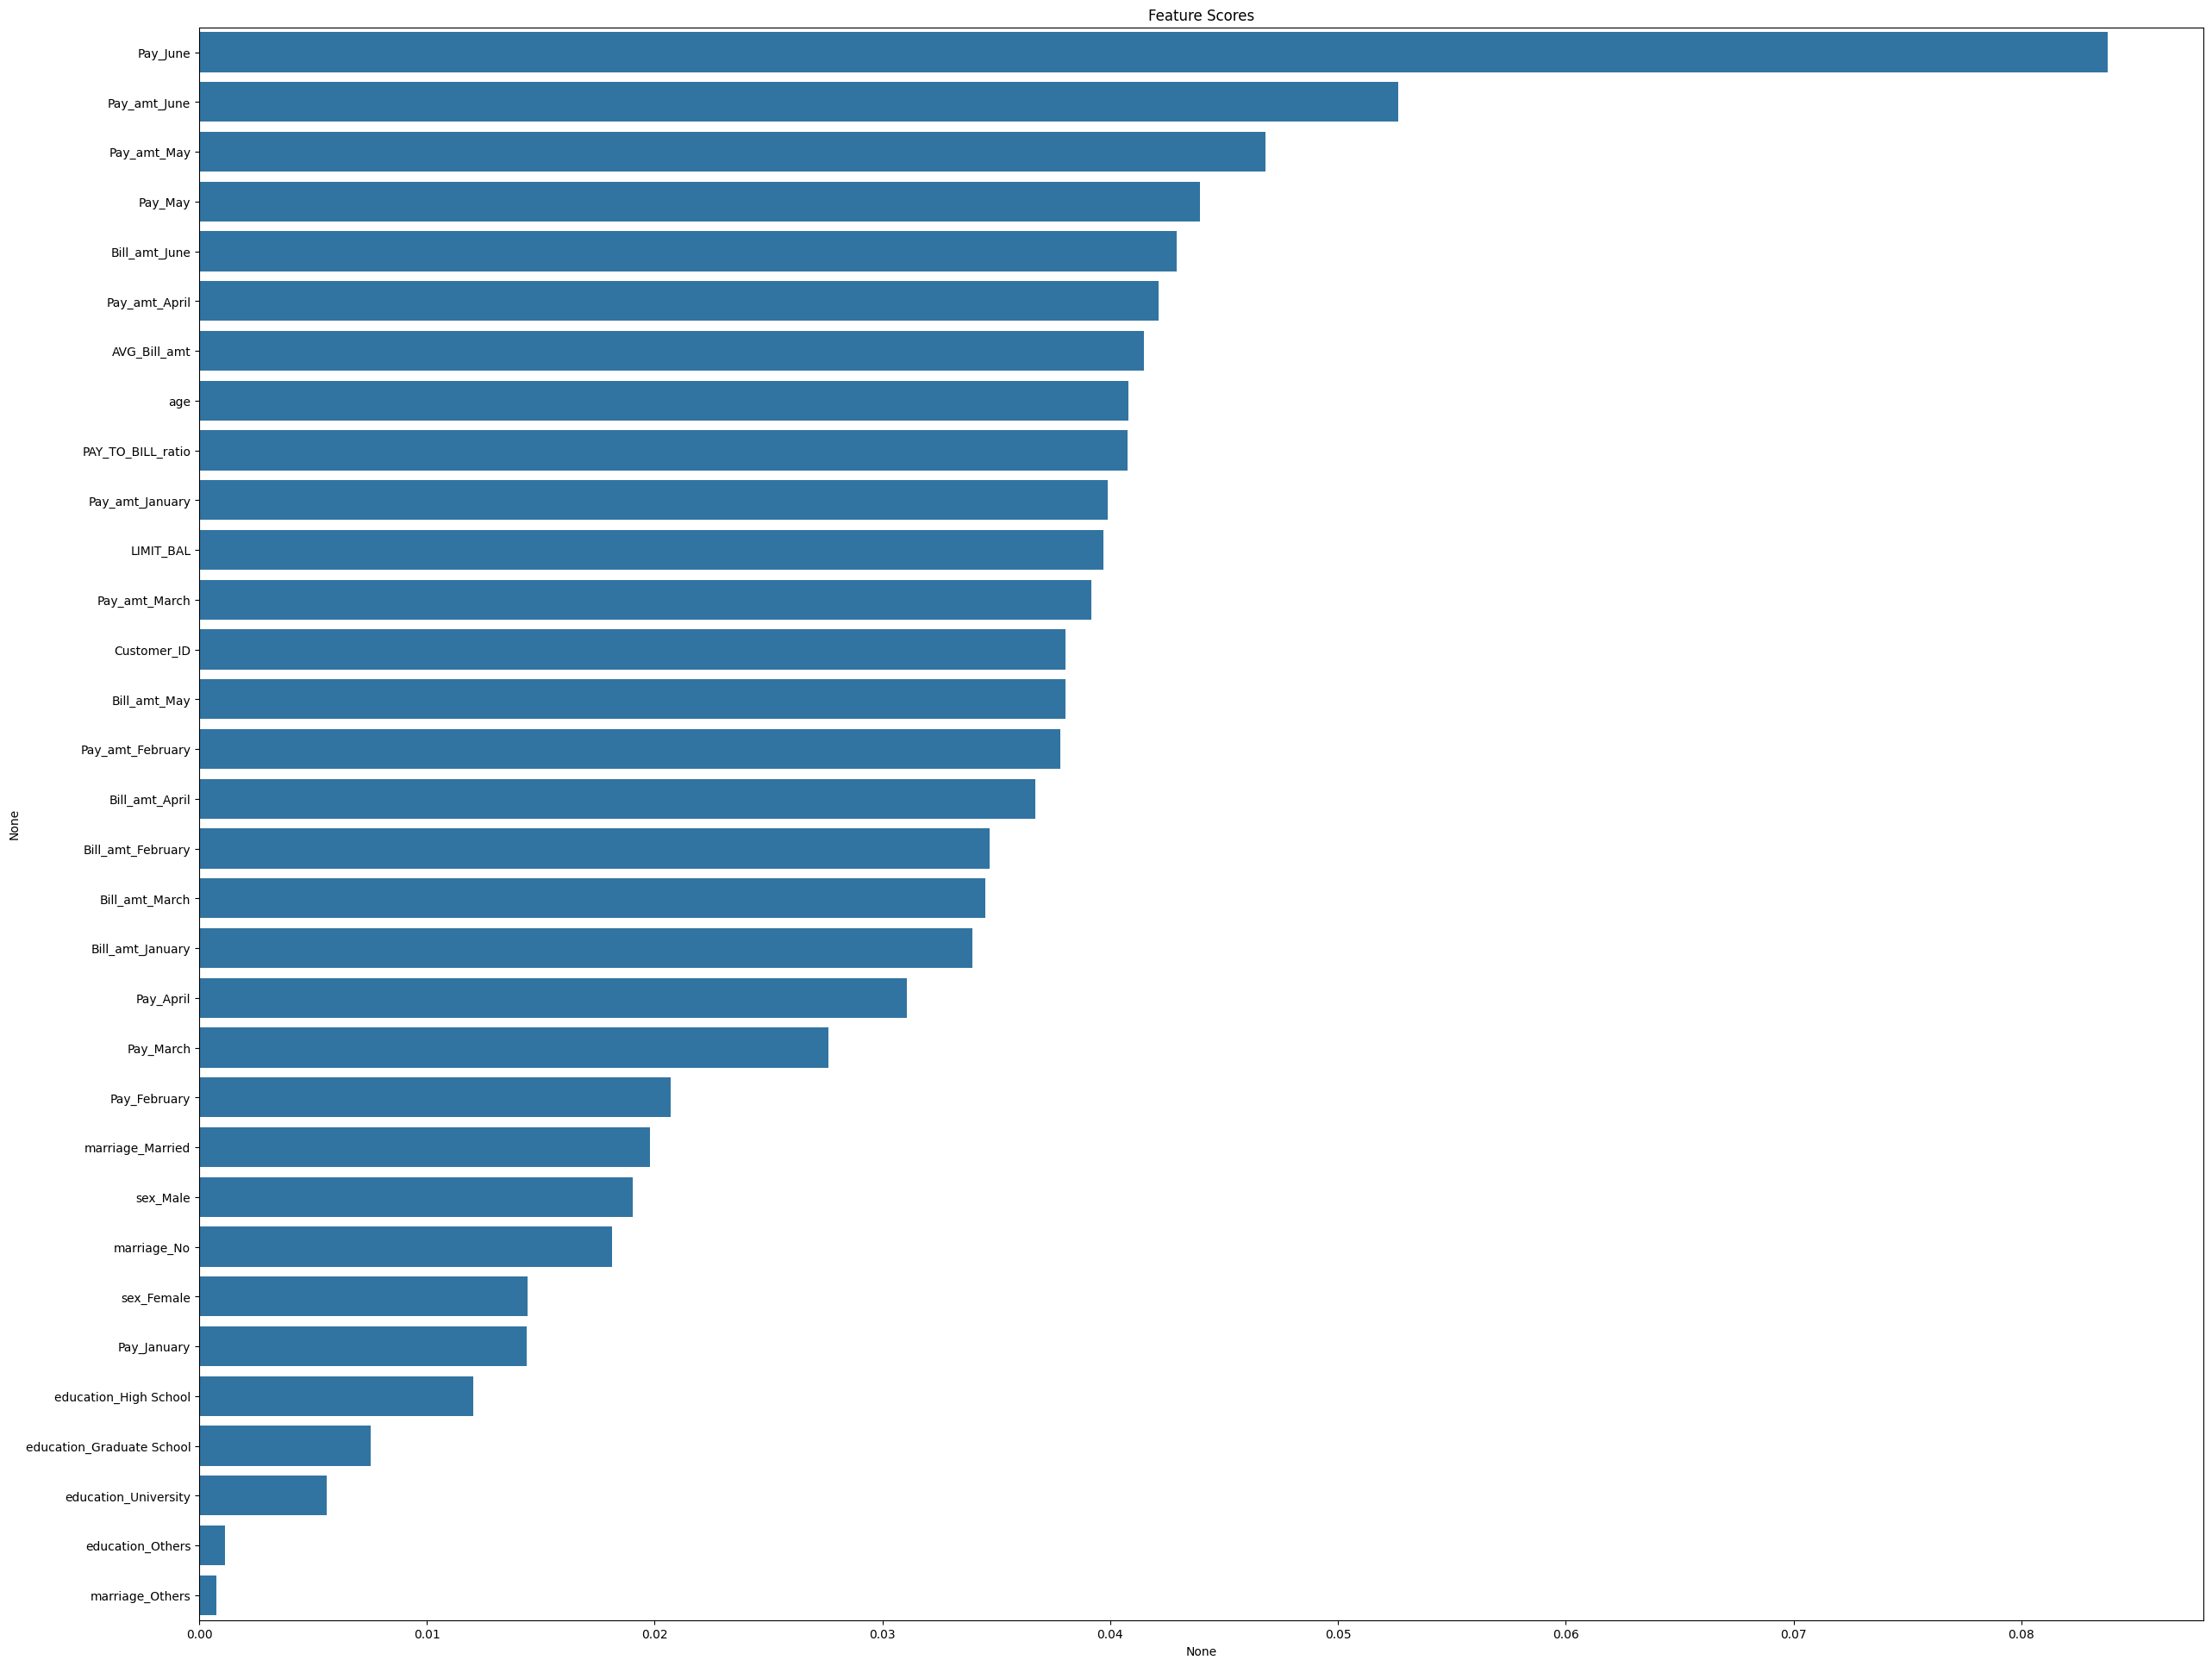

In [ ]:
f, ax = plt.subplots(figsize=(30,24))
ax = sns.barplot(x=feature_scores,
                 y=feature_scores.index)
ax.set_title('Feature Scores')
ax.set_yticklabels(feature_scores.index)
plt.show()

### Model With Top important features

In [ ]:
df_new = df_final[feature_scores.index[:20]]
df2_new = df2[feature_scores.index[:20]]
df_new['default'] = df_final['next_month_default']
X = df_new.drop('default', axis=1)
y = df_new['default']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## RandomForest with important Features

In [ ]:
rf = RandomForestClassifier(random_state=6)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=6)

In [ ]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)
val_pred = rf.predict(df2_new)
np.sum(val_pred == 1)

np.int64(252)

In [ ]:
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)

print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)

Accuracy:  0.8803933620159803
Precision:  0.8992660086054164
Recall:  0.8607073643410853
F1 Score:  0.8795643025126872


## Creating New features

### 1-Bill amount average

In [ ]:
df_final['Bill_amt_avg']=(df_final['Bill_amt_January']+df_final['Bill_amt_February']+df_final['Bill_amt_March']+df_final['Bill_amt_April']+df_final['Bill_amt_May']+df_final['Bill_amt_June'])/6
df2['Bill_amt_avg']=(df2['Bill_amt_January']+df2['Bill_amt_February']+df2['Bill_amt_March']+df2['Bill_amt_April']+df2['Bill_amt_May']+df2['Bill_amt_June'])/6

### 2-Bill Pay Value

In [ ]:
df_final['Bill_pay_value'] = ((df_final['Pay_amt_January'] - df_final['Bill_amt_January']) + (df_final['Pay_amt_February'] - df_final['Bill_amt_February']) + (df_final['Pay_amt_March'] - df_final['Bill_amt_March']) + (df_final['Pay_amt_April'] - df_final['Bill_amt_April']) + (df_final['Pay_amt_May'] - df_final['Bill_amt_May']) + (df_final['Pay_amt_June'] - df_final['Bill_amt_June']))
df2['Bill_pay_value']=((df2['Pay_amt_January'] - df2['Bill_amt_January']) + (df2['Pay_amt_February'] - df2['Bill_amt_February']) + (df2['Pay_amt_March'] - df2['Bill_amt_March']) + (df2['Pay_amt_April'] - df2['Bill_amt_April']) + (df2['Pay_amt_May'] - df2['Bill_amt_May']) + (df2['Pay_amt_June'] - df2['Bill_amt_June']))

In [ ]:
df_final.head()

,Customer_ID,LIMIT_BAL,age,Pay_June,Pay_May,Pay_April,Pay_March,Pay_February,Pay_January,Bill_amt_June,...,marriage_No,marriage_Others,education_Graduate School,education_High School,education_Others,education_University,sex_Female,sex_Male,Bill_amt_avg,Bill_pay_value
0,5017,60000,25.0,2,2,2,0,0,0,60323.86,...,True,False,False,False,False,True,True,False,41511.498333,-241111.88
1,5018,290000,24.0,0,0,-2,-2,-1,0,11157.67,...,True,False,True,False,False,False,False,True,2535.076667,-11160.47
2,5019,180000,63.0,0,0,0,0,0,0,47930.96,...,False,False,False,False,False,True,True,False,50421.683333,-290474.38
3,5020,210000,43.0,0,0,0,0,0,0,91152.44,...,False,False,False,False,False,True,False,True,86229.755000,-498929.03
4,5021,280000,32.0,-2,-2,-2,-2,-2,-2,19666.40,...,True,False,True,False,False,False,True,False,11814.253333,-19571.32


In [ ]:
X = df_final.drop(columns='next_month_default',axis=1)
y = df_final['next_month_default']

In [ ]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Gradient Boosting

In [54]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train,y_train)

GradientBoostingClassifier()

In [55]:
test_pred = model.predict(X_test)
val_pred = model.predict(df2)
np.sum(val_pred==1)

np.int64(963)

In [57]:
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)

print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)
print('F2 Score', f2)
print('roc_auc',roc_auc)


Accuracy:  0.8183159188690842
Precision:  0.8455920709441836
Recall:  0.7853682170542635
F1 Score:  0.8143682491836222
F2 Score 0.7967167993708837
roc_auc 0.8188133822980327


## Catboost

In [73]:
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
model.fit(X_train, y_train)

0:	learn: 0.6594900	total: 126ms	remaining: 12.5s
1:	learn: 0.6330410	total: 143ms	remaining: 7.02s
2:	learn: 0.6079707	total: 155ms	remaining: 5.01s
3:	learn: 0.5885831	total: 168ms	remaining: 4.04s
4:	learn: 0.5741380	total: 182ms	remaining: 3.47s
5:	learn: 0.5628253	total: 194ms	remaining: 3.04s
6:	learn: 0.5532924	total: 220ms	remaining: 2.92s
7:	learn: 0.5446603	total: 244ms	remaining: 2.8s
8:	learn: 0.5345126	total: 264ms	remaining: 2.67s
9:	learn: 0.5283363	total: 298ms	remaining: 2.68s
10:	learn: 0.5218952	total: 332ms	remaining: 2.69s
11:	learn: 0.5178633	total: 349ms	remaining: 2.56s
12:	learn: 0.5078637	total: 417ms	remaining: 2.79s
13:	learn: 0.5005867	total: 500ms	remaining: 3.07s
14:	learn: 0.4940327	total: 556ms	remaining: 3.15s
15:	learn: 0.4913061	total: 607ms	remaining: 3.19s
16:	learn: 0.4884453	total: 647ms	remaining: 3.16s
17:	learn: 0.4856058	total: 681ms	remaining: 3.1s
18:	learn: 0.4832493	total: 708ms	remaining: 3.02s
19:	learn: 0.4812934	total: 738ms	remaining

In [74]:
test_pred = model.predict(X_test)
val_pred = model.predict(df2)
np.sum(val_pred==1)

np.int64(760)

In [75]:
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)

print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)
print('F2 Score', f2)
print('roc_auc',roc_auc)

Accuracy:  0.8484326982175784
Precision:  0.8852808091562416
Recall:  0.8057170542635659
F1 Score:  0.8436271401395053
F2 Score 0.8204647491242785
roc_auc 0.8490776436778273


## RandomForest

In [59]:
rf= RandomForestClassifier(random_state=6)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=6)

In [63]:
train_test = rf.predict(X_train)
test_pred = rf.predict(X_test)
val_pred = rf.predict(df2)
np.sum(val_pred==1)

np.int64(953)

In [64]:
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)

print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)
print('F2 Score', f2)
print('roc_auc',roc_auc)

Accuracy:  0.8695759065765212
Precision:  0.8865641542727501
Recall:  0.8519864341085271
F1 Score:  0.8689314391599753
F2 Score 0.8586845060793984
roc_auc 0.8698414825895767


Using Ensemble methods for increasing model performance

## Ensemble methods - Combining random forest and GradientBoosting

In [66]:
model1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model2 = RandomForestClassifier(random_state=6)
ensemble_model = VotingClassifier(estimators=[('gb', model1), ('rf', model2)], voting='soft')
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('gb', GradientBoostingClassifier()),
                             ('rf', RandomForestClassifier(random_state=6))],
                 voting='soft')

In [67]:
test_pred = ensemble_model.predict(X_test)
val_pred = ensemble_model.predict(df2)
np.sum(val_pred==1)

np.int64(857)

In [68]:
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)

print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)
print('F2 Score', f2)
print('roc_auc',roc_auc)

Accuracy:  0.8544560540872772
Precision:  0.8758937691521961
Recall:  0.8309108527131783
F1 Score:  0.8528095474888115
F2 Score 0.8395339729782652
roc_auc 0.8548115531347273


## LightGBM

In [81]:
lgbm_model = lgbm.LGBMClassifier()

In [82]:
optimization_dict = {
    'max_depth': [2,4,6],
    'n_estimators': [50, 100, 200]
}
model = GridSearchCV(lgbm_model, optimization_dict, scoring='accuracy', verbose=1)
model.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12967, number of negative: 13064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4920
[LightGBM] [Info] Number of data points in the train set: 26031, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498137 -> initscore=-0.007453
[LightGBM] [Info] Start training from score -0.007453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [83]:
test_pred = model.predict(X_test)
val_pred = model.predict(df2)
np.sum(val_pred==1)

np.int64(567)

In [84]:
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)
print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)
print('F2 Score', f2)
print('roc_auc',roc_auc)

Accuracy:  0.8867854947756607
Precision:  0.9325600215807931
Recall:  0.8374515503875969
F1 Score:  0.8824505424377792
F2 Score 0.8548889658242247
roc_auc 0.8875303671578614


## XGBoost

In [85]:
f2_scorer = make_scorer(fbeta_score, beta=2)
xgb_model = xgb.XGBClassifier()
optimization_dict = {
    'max_depth': [2,4,6],
    'n_estimators': [50, 100, 200]
}
model = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', verbose=1)
model.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [86]:
test_pred = model.predict(X_test)
val_pred = model.predict(df2)
np.sum(val_pred==1)

np.int64(734)

In [87]:
cm = confusion_matrix(y_test, test_pred)
cm

array([[3668,  339],
       [ 626, 3502]])

In [88]:
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)

print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)
print('F2 Score', f2)
print('roc_auc',roc_auc)

Accuracy:  0.8813767670559312
Precision:  0.9117417339234575
Recall:  0.8483527131782945
F1 Score:  0.8789057598192997
F2 Score 0.8603154326143566
roc_auc 0.8818753832924164


## Model Comparison

In [90]:

# Store the results for each model
results = {}

# Gradient Boosting
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train,y_train)
test_pred = model.predict(X_test)
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)
results['Gradient Boosting'] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'F2 Score': f2, 'ROC AUC': roc_auc}

# RandomForest
rf= RandomForestClassifier(random_state=6)
rf.fit(X_train,y_train)
test_pred = rf.predict(X_test)
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)
results['RandomForest'] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'F2 Score': f2, 'ROC AUC': roc_auc}

# Ensemble methods - Combining random forest and GradientBoosting
model1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model2 = RandomForestClassifier(random_state=6)
ensemble_model = VotingClassifier(estimators=[('gb', model1), ('rf', model2)], voting='soft')
ensemble_model.fit(X_train, y_train)
test_pred = ensemble_model.predict(X_test)
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)
results['Ensemble (GB + RF)'] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'F2 Score': f2, 'ROC AUC': roc_auc}

# Catboost
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False) # Suppress verbose output
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)
results['CatBoost'] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'F2 Score': f2, 'ROC AUC': roc_auc}

# XGBoost
f2_scorer = make_scorer(fbeta_score, beta=2)
xgb_model = xgb.XGBClassifier()
optimization_dict = {
    'max_depth': [2,4,6],
    'n_estimators': [50, 100, 200]
}
model = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', verbose=0) # Suppress verbose output
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)
results['XGBoost'] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'F2 Score': f2, 'ROC AUC': roc_auc}

# LightGBM
lgbm_model = lgbm.LGBMClassifier()
optimization_dict = {
    'max_depth': [2,4,6],
    'n_estimators': [50, 100, 200]
}
model = GridSearchCV(lgbm_model, optimization_dict, scoring='accuracy', verbose=0) # Suppress verbose output
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
acc = accuracy_score(y_test,test_pred)
prec = precision_score(y_test,test_pred)
rec = recall_score(y_test,test_pred)
f1 = f1_score(y_test,test_pred)
f2 = fbeta_score(y_test,test_pred,beta=2)
roc_auc = roc_auc_score(y_test,test_pred)
results['LightGBM'] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'F2 Score': f2, 'ROC AUC': roc_auc}


# Create a DataFrame from the results
comparison_df = pd.DataFrame.from_dict(results, orient='index')

# Display the comparison table
comparison_df


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12967, number of negative: 13064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4920
[LightGBM] [Info] Number of data points in the train set: 26031, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498137 -> initscore=-0.007453
[LightGBM] [Info] Start training from score -0.007453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,Accuracy,Precision,Recall,F1 Score,F2 Score,ROC AUC
Gradient Boosting,0.818316,0.845592,0.785368,0.814368,0.796717,0.818813
RandomForest,0.869576,0.886564,0.851986,0.868931,0.858685,0.869841
Ensemble (GB + RF),0.854456,0.875894,0.830911,0.852810,0.839534,0.854812
CatBoost,0.848433,0.885281,0.805717,0.843627,0.820465,0.849078
XGBoost,0.881377,0.911742,0.848353,0.878906,0.860315,0.881875
LightGBM,0.886785,0.932560,0.837452,0.882451,0.854889,0.887530


## OUTPUT CSV

In [89]:
output_df = pd.DataFrame({
    'Customer_ID':df2['Customer_ID'],
    'next_month_default':val_pred
})
output_df.to_csv('submission_22112007.csv',index=False)